# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [21]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

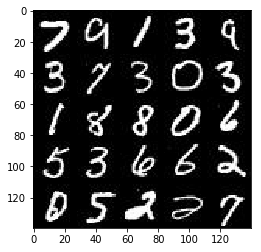

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

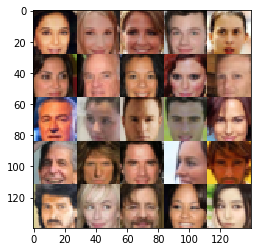

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return (real_input, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [40]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(x1, alpha * x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2, alpha * bn2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3, alpha * bn3)
        #4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha * x1)
        #7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha * x2)
        #14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha * x3)
        #28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #28x28x3
        
        output = tf.tanh(logits)
        
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z, out_channel_dim, is_train=True, alpha=0.2)
    disc_model_real, disc_logits_real = discriminator(input_real, alpha=0.2)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True, alpha=0.2)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return (disc_loss, gen_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars) 
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})


                if steps % 10 == 0:
                    # At the end of each 10 epochs, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    # At the end of each 100 epochs, show generator output
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 2.9320... Generator Loss: 0.0867
Epoch 1/2... Discriminator Loss: 2.5569... Generator Loss: 0.1124
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 0.4507
Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.5112
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 1.1371
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.6428... Generator Loss: 2.0502
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.6841


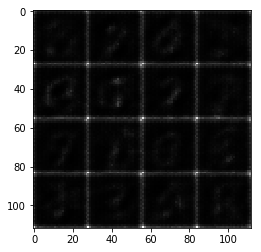

Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.4429
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.2153
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.4845... Generator Loss: 0.3951


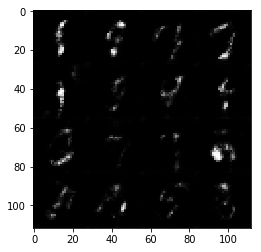

Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.3658
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 2.7036
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.6242
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 1.3455


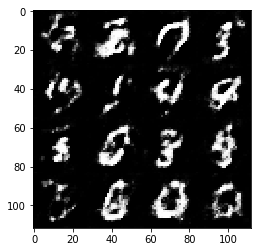

Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 0.9106
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.5930
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 0.7131... Generator Loss: 1.3536
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.7376
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 2.7440
Epoch 1/2... Discriminator Loss: 1.5966... Generator Loss: 0.3239


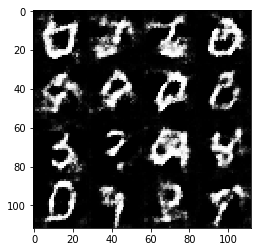

Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.3226
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.6320
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 1.0811
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.4470


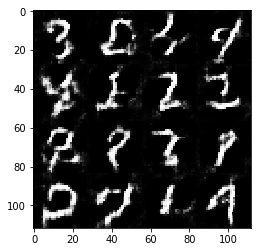

Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 2.3816
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.3139
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.3671
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.9597
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 0.8836


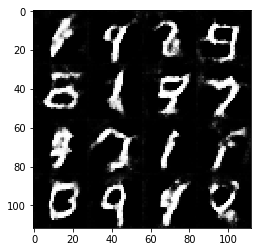

Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.6247... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 1.8116
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.0165... Generator Loss: 1.4947
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 1.0114


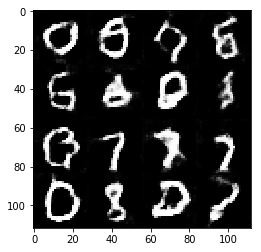

Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.7281
Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 0.2791
Epoch 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.4346
Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 1.8915
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 2.1629
Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.3443


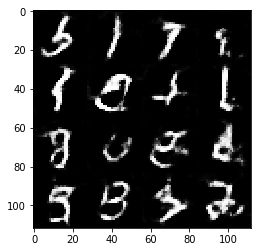

Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.1286
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.0585


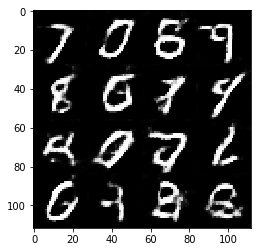

Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.1050
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.0483
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 0.9157
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.3890
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 1.3901
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 0.5891


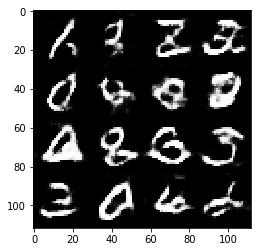

Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.4634
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 0.8257
Epoch 1/2... Discriminator Loss: 0.7679... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 0.7641


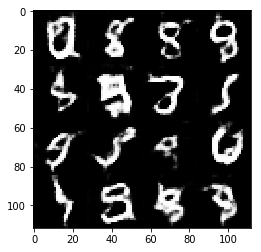

Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.4571... Generator Loss: 0.3547
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 2.7630


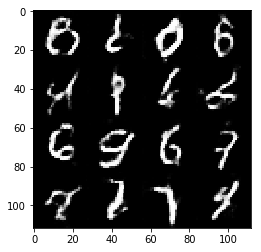

Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 1.2348
Epoch 1/2... Discriminator Loss: 0.7822... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 1.5572
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 0.6518
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 1.3575
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.1363


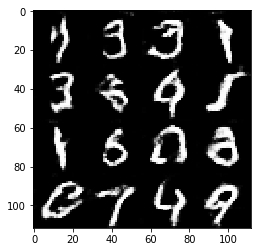

Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 1.4653... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 3.0444... Generator Loss: 4.3648
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.5819
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.7218


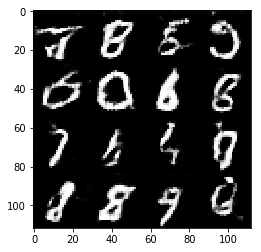

Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.8731... Generator Loss: 0.2210
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.4629
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 1.1270
Epoch 1/2... Discriminator Loss: 0.6161... Generator Loss: 1.1591
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.5472
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 1.0272


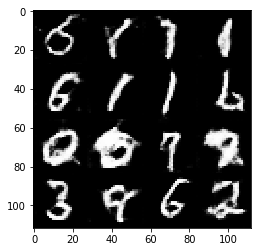

Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 0.8783
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.1444
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 1.5924
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.6482
Epoch 1/2... Discriminator Loss: 0.6260... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 0.7856


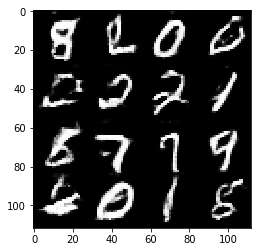

Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.4918
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 0.8832
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 1.5261
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.5513
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 0.7408


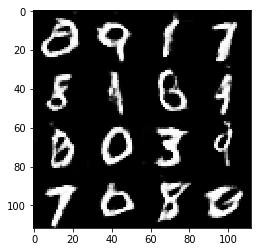

Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.0141
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 1.9191
Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 1.2672
Epoch 1/2... Discriminator Loss: 0.7719... Generator Loss: 2.0995
Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 0.5679


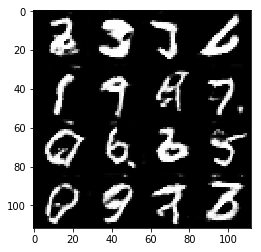

Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.5831
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 2.7764
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.1156
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.5660


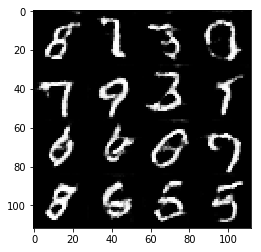

Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.0994
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.4251
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 1.9006
Epoch 2/2... Discriminator Loss: 0.5092... Generator Loss: 1.3965
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 0.8701
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 0.8627


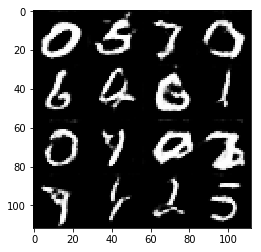

Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 1.6258
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 2.0800
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 1.0757... Generator Loss: 0.5540
Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 1.5865
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.6865


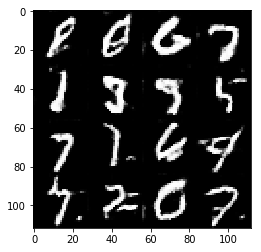

Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 2.8519
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 0.6167... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.5188
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 0.5771... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 0.4998... Generator Loss: 1.4870
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.0356


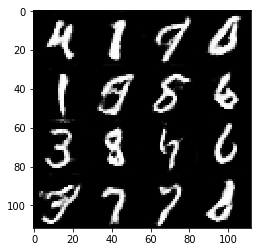

Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 1.2600
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.4354
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 2.5983
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 1.9843
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 0.4802... Generator Loss: 1.9682
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 1.1111
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 0.5980


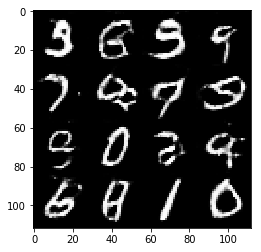

Epoch 2/2... Discriminator Loss: 1.8920... Generator Loss: 3.9784
Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 1.5964
Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 0.5013... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 0.4733... Generator Loss: 1.4561
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 0.5446... Generator Loss: 1.1451
Epoch 2/2... Discriminator Loss: 0.6512... Generator Loss: 1.2723


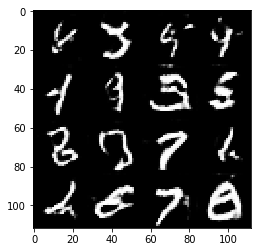

Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 2.1239
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 1.4469
Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.2690
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 2.0249
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 3.2821


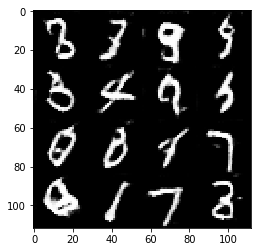

Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.4238
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 0.5477... Generator Loss: 1.6085
Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 0.4897... Generator Loss: 1.3616
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 0.9152
Epoch 2/2... Discriminator Loss: 0.6242... Generator Loss: 1.0536
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 0.8429


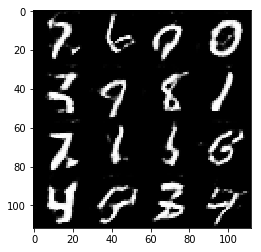

Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 0.3115... Generator Loss: 2.4763
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 0.5709... Generator Loss: 1.1761
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 1.3690
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 0.3476... Generator Loss: 2.0324


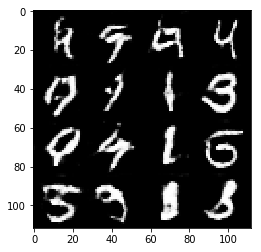

Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 0.4632... Generator Loss: 2.2695
Epoch 2/2... Discriminator Loss: 0.4432... Generator Loss: 2.2709
Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 1.8098
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 1.7906
Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 4.3754
Epoch 2/2... Discriminator Loss: 1.3165... Generator Loss: 0.4614
Epoch 2/2... Discriminator Loss: 0.4172... Generator Loss: 1.3053
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 0.5817... Generator Loss: 1.6713


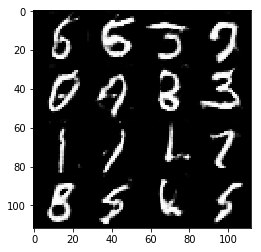

Epoch 2/2... Discriminator Loss: 0.6197... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 0.4373... Generator Loss: 1.5700
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 1.3474
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 1.5862
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 1.2398
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 0.7718


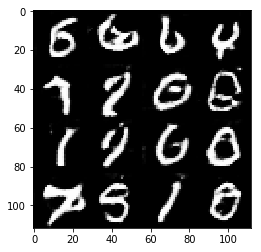

Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 1.7022
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 1.8745
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 0.4320... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.4913
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 0.4956... Generator Loss: 1.4629
Epoch 2/2... Discriminator Loss: 0.2836... Generator Loss: 2.0084


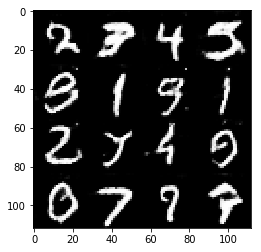

Epoch 2/2... Discriminator Loss: 1.8001... Generator Loss: 0.3490
Epoch 2/2... Discriminator Loss: 1.5952... Generator Loss: 0.3655
Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 1.4297
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.1848
Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 0.3450... Generator Loss: 2.0376
Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 0.4531
Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 0.4827... Generator Loss: 1.4142


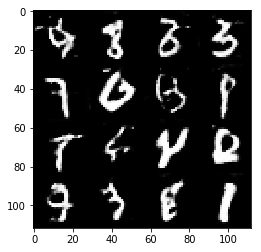

Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 1.5790
Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 1.6244
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.7141
Epoch 2/2... Discriminator Loss: 0.4427... Generator Loss: 1.5839
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.6488
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 0.3821... Generator Loss: 1.8459
Epoch 2/2... Discriminator Loss: 0.4397... Generator Loss: 1.4637


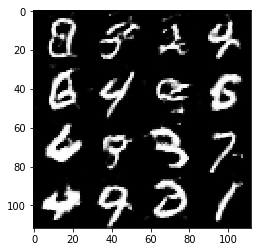

Epoch 2/2... Discriminator Loss: 1.7314... Generator Loss: 0.2852
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 0.3431... Generator Loss: 1.8923
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 3.8846
Epoch 2/2... Discriminator Loss: 0.4034... Generator Loss: 1.5409
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.3822
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 0.5567... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 1.6842
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 0.9000


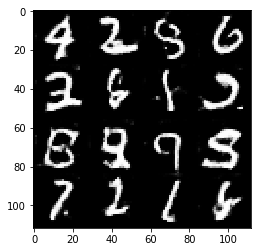

Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 0.5139... Generator Loss: 1.3073
Epoch 2/2... Discriminator Loss: 2.1558... Generator Loss: 0.2494
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.3349
Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 1.2818
Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 3.0904
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 4.1154
Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 1.2738
Epoch 2/2... Discriminator Loss: 0.2452... Generator Loss: 2.5434


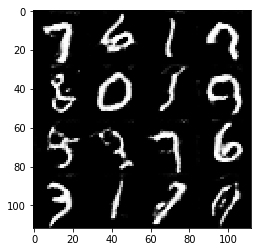

Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.3299
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 0.3842... Generator Loss: 1.6186
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 1.4799
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 0.6324
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 2.1407


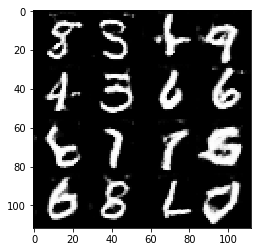

Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 1.7954
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 3.5747
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 0.9794
Epoch 2/2... Discriminator Loss: 0.4956... Generator Loss: 1.2961
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 1.3536
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 0.8020
Epoch 2/2... Discriminator Loss: 0.4566... Generator Loss: 1.5420
Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 1.9766
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 0.3118... Generator Loss: 1.9780


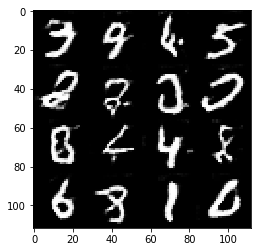

Epoch 2/2... Discriminator Loss: 0.4767... Generator Loss: 1.3671
Epoch 2/2... Discriminator Loss: 0.3442... Generator Loss: 1.7522
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 2.1964
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 0.3839... Generator Loss: 1.8016
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 1.3158
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 0.3437... Generator Loss: 2.6999
Epoch 2/2... Discriminator Loss: 0.5494... Generator Loss: 1.1661


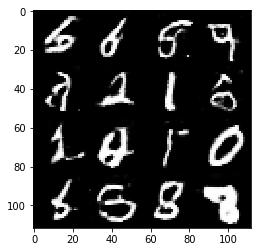

Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 1.4633
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 2.2160... Generator Loss: 0.2428
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 2.0967
Epoch 2/2... Discriminator Loss: 0.5139... Generator Loss: 1.3483


In [51]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 2.2552... Generator Loss: 0.1493
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 2.0404... Generator Loss: 0.2196
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 5.0894


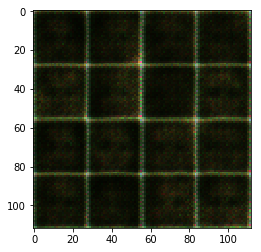

Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 2.1620
Epoch 1/1... Discriminator Loss: 1.8942... Generator Loss: 0.2733
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 1.9861
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 4.5637
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 2.3222
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.7348


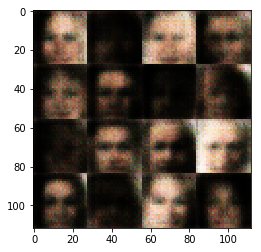

Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 2.1747
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 3.3039
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 2.1302
Epoch 1/1... Discriminator Loss: 0.1999... Generator Loss: 3.1997
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 3.7632
Epoch 1/1... Discriminator Loss: 1.8888... Generator Loss: 0.2591


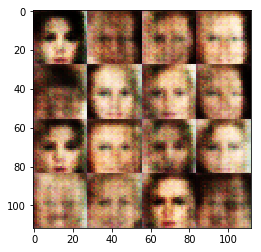

Epoch 1/1... Discriminator Loss: 1.8952... Generator Loss: 0.2374
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.3215
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 2.7819
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.6828
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.5735
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 0.2454... Generator Loss: 3.5687


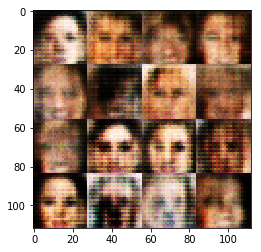

Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 0.2099... Generator Loss: 3.0188
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 5.2064
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.3716
Epoch 1/1... Discriminator Loss: 0.3046... Generator Loss: 7.5871
Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 2.5334
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 5.1219


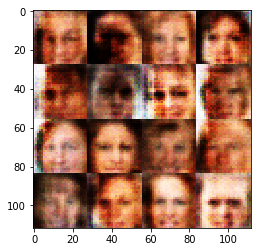

Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 5.6897
Epoch 1/1... Discriminator Loss: 0.1003... Generator Loss: 5.6654
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 1.4531
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 6.1324
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.3188... Generator Loss: 8.8017
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 4.3147
Epoch 1/1... Discriminator Loss: 0.1308... Generator Loss: 3.1163
Epoch 1/1... Discriminator Loss: 0.1219... Generator Loss: 4.2222
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.4868


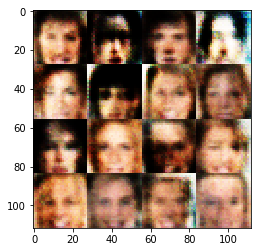

Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 6.2625
Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 2.5612
Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 4.7729
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 1.6863
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 4.4764
Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 6.7213
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 9.5351


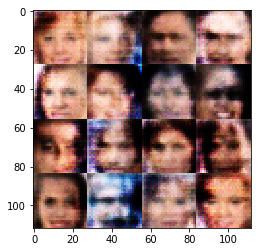

Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 0.0728... Generator Loss: 5.0892
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.0553... Generator Loss: 5.9657
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 0.2389... Generator Loss: 2.9131
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 4.8867
Epoch 1/1... Discriminator Loss: 0.2358... Generator Loss: 2.1951
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 5.2849


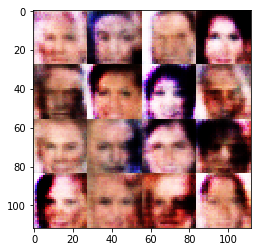

Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 7.5857
Epoch 1/1... Discriminator Loss: 0.1215... Generator Loss: 3.0776
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 2.6657
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 2.5891
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 6.3846
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 3.7556
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 6.5665
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 8.1499
Epoch 1/1... Discriminator Loss: 0.1134... Generator Loss: 3.3768


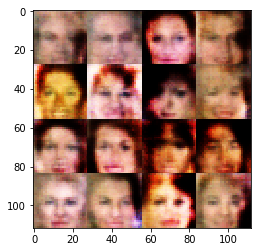

Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 5.4622
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 3.8008
Epoch 1/1... Discriminator Loss: 2.3386... Generator Loss: 0.1761
Epoch 1/1... Discriminator Loss: 2.4525... Generator Loss: 4.8921
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 3.9179
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 4.1558
Epoch 1/1... Discriminator Loss: 0.1438... Generator Loss: 3.0993
Epoch 1/1... Discriminator Loss: 0.1355... Generator Loss: 3.4106
Epoch 1/1... Discriminator Loss: 0.0551... Generator Loss: 5.6520


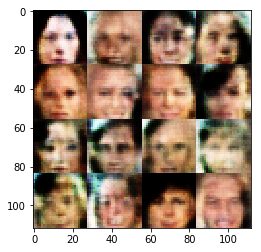

Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 3.4137
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 4.9539
Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 5.4902
Epoch 1/1... Discriminator Loss: 0.1198... Generator Loss: 3.2580
Epoch 1/1... Discriminator Loss: 0.0709... Generator Loss: 5.2353
Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 6.5704
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.4501
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 2.6027
Epoch 1/1... Discriminator Loss: 0.3367... Generator Loss: 1.6189


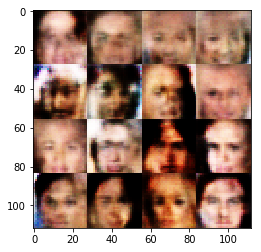

Epoch 1/1... Discriminator Loss: 0.1279... Generator Loss: 5.3674
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 4.9202
Epoch 1/1... Discriminator Loss: 0.1599... Generator Loss: 6.5555
Epoch 1/1... Discriminator Loss: 0.2093... Generator Loss: 7.9521
Epoch 1/1... Discriminator Loss: 0.0985... Generator Loss: 4.2225
Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 5.1374
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 4.1592
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 5.5422
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 5.7873
Epoch 1/1... Discriminator Loss: 0.2410... Generator Loss: 4.6447


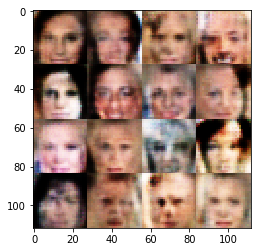

Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 4.1329
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 4.5773
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 3.1733
Epoch 1/1... Discriminator Loss: 0.1775... Generator Loss: 4.3467
Epoch 1/1... Discriminator Loss: 0.2423... Generator Loss: 2.0685
Epoch 1/1... Discriminator Loss: 0.1678... Generator Loss: 5.5399
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 3.1379
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.0962... Generator Loss: 3.8484
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.6123


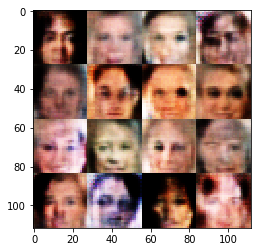

Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 5.2020
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 3.3358
Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 4.5037
Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 4.7701
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 2.7269
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 2.0880
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 4.3290
Epoch 1/1... Discriminator Loss: 0.0329... Generator Loss: 5.0402
Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 3.5727
Epoch 1/1... Discriminator Loss: 0.1111... Generator Loss: 3.7040


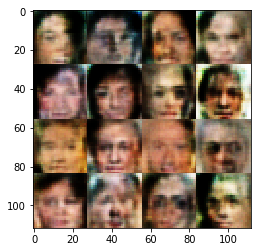

Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 4.9334
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 4.5019
Epoch 1/1... Discriminator Loss: 2.9553... Generator Loss: 0.0812
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 2.9063
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 3.0547
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.1543... Generator Loss: 2.5959
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 3.8247
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 2.8575


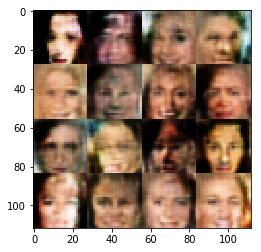

Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 5.3665
Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 2.1786
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 3.3982
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 2.0927
Epoch 1/1... Discriminator Loss: 0.2185... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 3.3701
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 1.6156
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 1.9279
Epoch 1/1... Discriminator Loss: 0.2253... Generator Loss: 2.3434


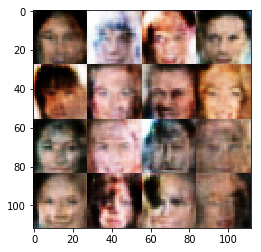

Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 2.9016
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 4.3582
Epoch 1/1... Discriminator Loss: 0.0912... Generator Loss: 3.5988
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 8.0395
Epoch 1/1... Discriminator Loss: 0.2537... Generator Loss: 6.0272
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 3.8383


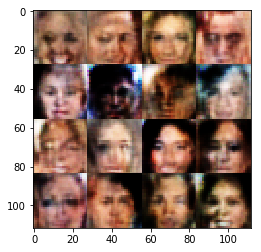

Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 2.6478
Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 3.7338
Epoch 1/1... Discriminator Loss: 0.2809... Generator Loss: 5.5501
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.1175... Generator Loss: 3.2401
Epoch 1/1... Discriminator Loss: 0.2832... Generator Loss: 1.8468
Epoch 1/1... Discriminator Loss: 0.1577... Generator Loss: 2.4891
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 1.6302
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 5.0265
Epoch 1/1... Discriminator Loss: 0.1969... Generator Loss: 2.2836


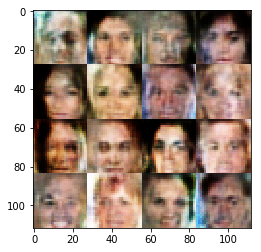

Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 7.4745
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.3809
Epoch 1/1... Discriminator Loss: 2.5128... Generator Loss: 3.4491
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 0.0961... Generator Loss: 3.9857
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.2241... Generator Loss: 2.2409
Epoch 1/1... Discriminator Loss: 0.2476... Generator Loss: 3.3028


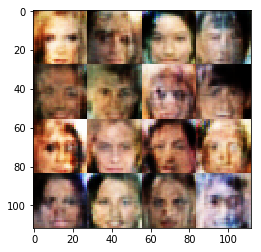

Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 3.0313
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 3.8875
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 5.5157
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 2.4015
Epoch 1/1... Discriminator Loss: 0.2350... Generator Loss: 5.9426
Epoch 1/1... Discriminator Loss: 0.1757... Generator Loss: 2.3995
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 9.4474
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.7888
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 5.1116


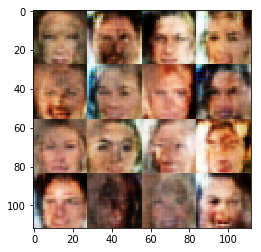

Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 2.0361
Epoch 1/1... Discriminator Loss: 0.0964... Generator Loss: 3.6448
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 3.0074
Epoch 1/1... Discriminator Loss: 0.1171... Generator Loss: 3.1738
Epoch 1/1... Discriminator Loss: 0.1998... Generator Loss: 2.5562
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 3.7470
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 3.4192
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6564


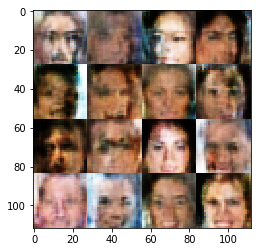

Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 1.9788
Epoch 1/1... Discriminator Loss: 0.2769... Generator Loss: 2.1106
Epoch 1/1... Discriminator Loss: 0.2752... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 2.7785
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.1156... Generator Loss: 4.1859
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 1.1114


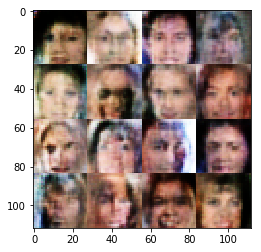

Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 3.2879
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 2.1428
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 4.3372
Epoch 1/1... Discriminator Loss: 0.2320... Generator Loss: 2.2794
Epoch 1/1... Discriminator Loss: 0.2217... Generator Loss: 2.8907
Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 2.4007
Epoch 1/1... Discriminator Loss: 0.3206... Generator Loss: 1.6748
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 2.9237
Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 2.9520
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 3.8011


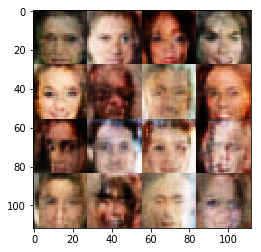

Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 3.3150
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 0.1612... Generator Loss: 2.8481
Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 2.9615
Epoch 1/1... Discriminator Loss: 0.1344... Generator Loss: 3.8986
Epoch 1/1... Discriminator Loss: 0.2645... Generator Loss: 1.8961
Epoch 1/1... Discriminator Loss: 0.3156... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 0.1803... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 0.0654... Generator Loss: 3.5125
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 4.1592


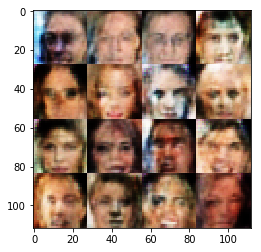

Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 6.6134
Epoch 1/1... Discriminator Loss: 1.8877... Generator Loss: 0.2451
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 4.1579
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 2.1073
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 6.4511
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 2.3897
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 2.8186
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 1.4115
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 2.6714


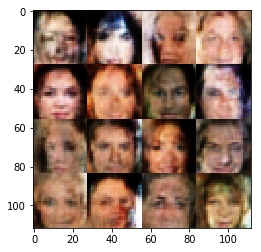

Epoch 1/1... Discriminator Loss: 0.0212... Generator Loss: 6.8201
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 6.3490
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.1411... Generator Loss: 4.1621
Epoch 1/1... Discriminator Loss: 1.8162... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 3.3149
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.6987
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 4.2879


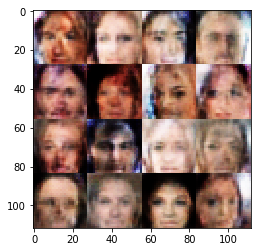

Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 0.1485... Generator Loss: 2.5762
Epoch 1/1... Discriminator Loss: 0.1397... Generator Loss: 2.8415
Epoch 1/1... Discriminator Loss: 0.1992... Generator Loss: 2.5314
Epoch 1/1... Discriminator Loss: 0.1385... Generator Loss: 2.4890
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 4.3486
Epoch 1/1... Discriminator Loss: 1.8419... Generator Loss: 0.2597
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 1.1891


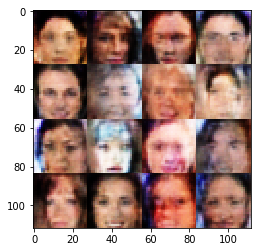

Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 1.6671
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 0.2909... Generator Loss: 1.9694
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 1.3317
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 2.6660
Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 7.6337
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 2.4571
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 3.5323


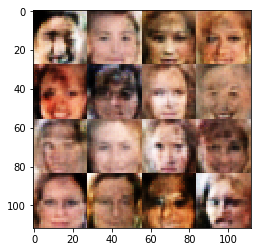

Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 0.1577... Generator Loss: 3.4886
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 3.4017
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 3.6184
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 2.4586
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 5.3330
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 3.2218
Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 4.4539


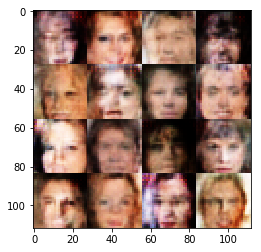

Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: 0.3246... Generator Loss: 1.6326
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 5.8506
Epoch 1/1... Discriminator Loss: 0.3768... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 0.2161... Generator Loss: 2.0591
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 0.1438... Generator Loss: 2.7461


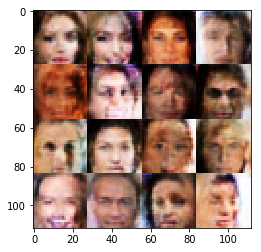

Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 2.0261
Epoch 1/1... Discriminator Loss: 0.1747... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 0.1371... Generator Loss: 2.8004
Epoch 1/1... Discriminator Loss: 0.1063... Generator Loss: 3.5985
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 4.1966
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 2.6035
Epoch 1/1... Discriminator Loss: 0.1660... Generator Loss: 2.5622
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 3.6338
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 2.1849
Epoch 1/1... Discriminator Loss: 0.1475... Generator Loss: 2.6195


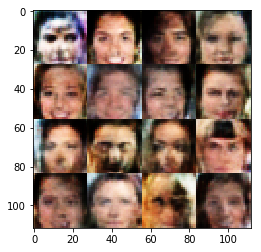

Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 2.6622
Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 3.9293
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 6.7434
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 3.2332
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 2.9200... Generator Loss: 0.3051
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 2.0817
Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 2.4788


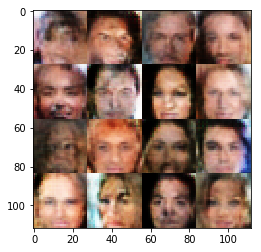

Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.1738... Generator Loss: 3.0380
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 2.8339
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 3.1471
Epoch 1/1... Discriminator Loss: 0.0334... Generator Loss: 8.9344
Epoch 1/1... Discriminator Loss: 0.0996... Generator Loss: 3.8874
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.3003
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 2.2837
Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 2.0568


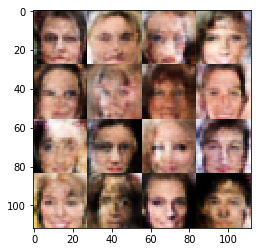

Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 6.7916
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 1.9180
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 3.8431
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 0.1625... Generator Loss: 3.1619


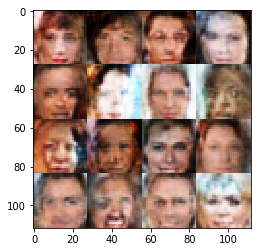

Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 2.2596
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 2.8600
Epoch 1/1... Discriminator Loss: 0.0359... Generator Loss: 4.0695
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 2.1281
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 3.6330
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 2.0470


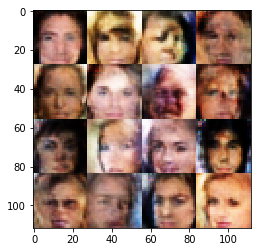

Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 3.1024
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 2.6039
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 3.9360
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.3527... Generator Loss: 1.7445
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 2.2819
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 1.9946


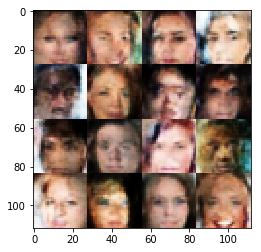

Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.2783
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 4.6848
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 2.8840
Epoch 1/1... Discriminator Loss: 0.1608... Generator Loss: 3.8596
Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 2.9811
Epoch 1/1... Discriminator Loss: 0.2821... Generator Loss: 1.9685
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 2.9621
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 5.1306


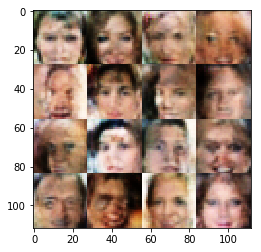

Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 2.3850
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.4917
Epoch 1/1... Discriminator Loss: 0.3010... Generator Loss: 2.4873
Epoch 1/1... Discriminator Loss: 0.1565... Generator Loss: 2.5690
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.5860... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 2.5117
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 5.7991


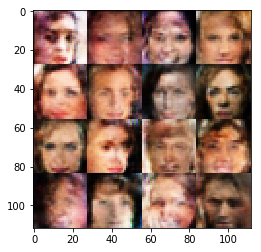

Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 1.8182
Epoch 1/1... Discriminator Loss: 0.2099... Generator Loss: 2.3425
Epoch 1/1... Discriminator Loss: 0.2456... Generator Loss: 1.9941
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 1.5574
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.5313
Epoch 1/1... Discriminator Loss: 0.1270... Generator Loss: 3.1912
Epoch 1/1... Discriminator Loss: 0.1363... Generator Loss: 2.6325
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 4.5298
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 3.6516


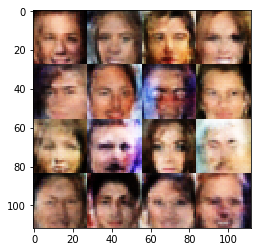

Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 3.7157
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 3.6250
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 2.6954
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 2.6241
Epoch 1/1... Discriminator Loss: 2.3091... Generator Loss: 0.1883
Epoch 1/1... Discriminator Loss: 0.2928... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 3.0337
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 1.7073
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 2.5435


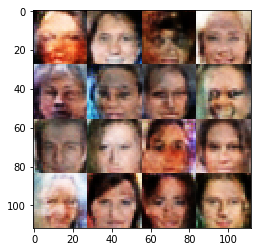

Epoch 1/1... Discriminator Loss: 0.0561... Generator Loss: 4.4943
Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 3.1400
Epoch 1/1... Discriminator Loss: 0.2110... Generator Loss: 3.0512
Epoch 1/1... Discriminator Loss: 0.2722... Generator Loss: 1.7170
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 2.1425
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 3.3867
Epoch 1/1... Discriminator Loss: 1.9279... Generator Loss: 6.1585
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 2.3717... Generator Loss: 0.1677


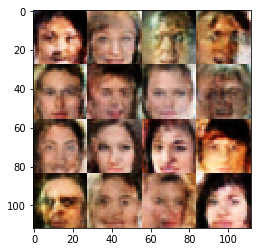

Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.2602
Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 2.9311
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.2573... Generator Loss: 2.0604
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 1.6476
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.2376... Generator Loss: 2.5463
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 2.5877


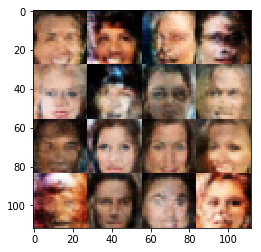

Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.8890
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 2.0843
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 1.6226
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 1.6907
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.2167... Generator Loss: 2.4679


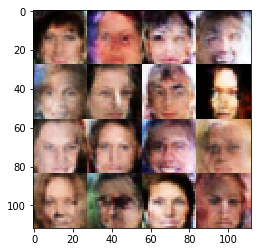

Epoch 1/1... Discriminator Loss: 0.2106... Generator Loss: 2.5526
Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 3.7981
Epoch 1/1... Discriminator Loss: 0.1483... Generator Loss: 3.7696
Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 2.6607
Epoch 1/1... Discriminator Loss: 0.3206... Generator Loss: 1.8010
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 2.0321
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 3.9571
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 1.4929


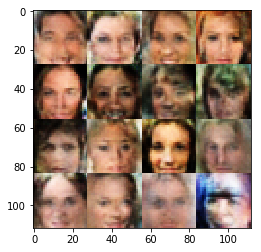

Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.3186... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 2.6402
Epoch 1/1... Discriminator Loss: 0.1254... Generator Loss: 2.9729
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 2.3733
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.1710... Generator Loss: 2.3338
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 0.2305... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.0345... Generator Loss: 5.9185


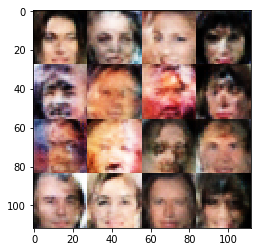

Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 2.7514
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 3.5194... Generator Loss: 10.1375
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 2.0989... Generator Loss: 0.2127
Epoch 1/1... Discriminator Loss: 0.2377... Generator Loss: 2.3154
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 1.2032


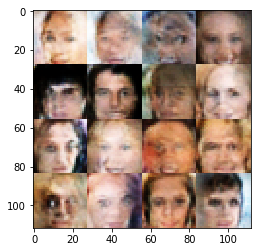

Epoch 1/1... Discriminator Loss: 0.1093... Generator Loss: 2.9385
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 1.5608
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.5788
Epoch 1/1... Discriminator Loss: 0.2878... Generator Loss: 2.4367
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 1.6627
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 0.2983... Generator Loss: 1.5487
Epoch 1/1... Discriminator Loss: 0.2885... Generator Loss: 1.7145


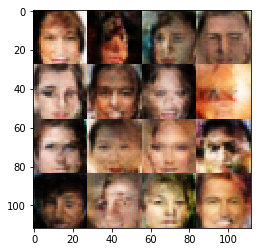

Epoch 1/1... Discriminator Loss: 0.0962... Generator Loss: 3.4471
Epoch 1/1... Discriminator Loss: 0.0573... Generator Loss: 4.9928
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 2.6756
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 3.2053
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 1.1873


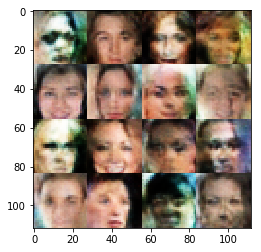

Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 1.5798
Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 0.1321... Generator Loss: 3.2047
Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 3.1026
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 6.0655
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 3.3919
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 6.0995
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.5025


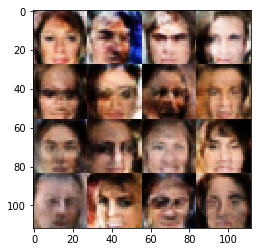

Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 3.8925
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 4.4433
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 3.5965
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.3061... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 0.1391... Generator Loss: 3.3912
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 2.6700
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 3.3389


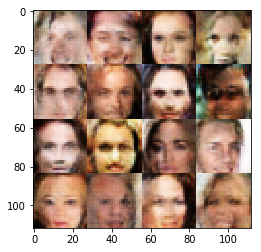

Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.1371
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 1.6376
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 6.4183
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 1.9448
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.3358
Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 4.0231
Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 2.6354
Epoch 1/1... Discriminator Loss: 0.1562... Generator Loss: 2.4816
Epoch 1/1... Discriminator Loss: 0.1608... Generator Loss: 3.6803


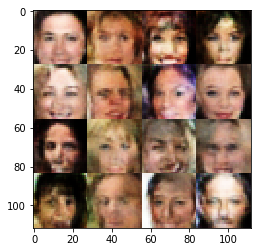

Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 4.4237
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 2.6833
Epoch 1/1... Discriminator Loss: 0.1493... Generator Loss: 2.5184
Epoch 1/1... Discriminator Loss: 0.1736... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.1483... Generator Loss: 3.6166
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 2.2672
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 5.3067
Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 2.3724
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.7659


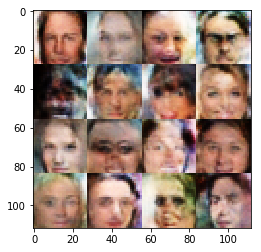

Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.1513... Generator Loss: 3.8483
Epoch 1/1... Discriminator Loss: 3.0143... Generator Loss: 0.1154
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 2.3748
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 0.2882... Generator Loss: 2.1444
Epoch 1/1... Discriminator Loss: 0.3238... Generator Loss: 1.8915
Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 2.0994


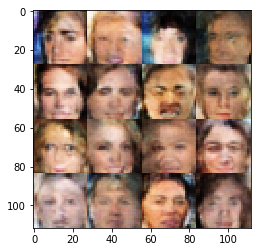

Epoch 1/1... Discriminator Loss: 0.2314... Generator Loss: 2.4545
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 3.0580
Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 2.8676
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 2.8229
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 0.1730... Generator Loss: 2.6478
Epoch 1/1... Discriminator Loss: 0.0691... Generator Loss: 4.0881
Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 2.3618


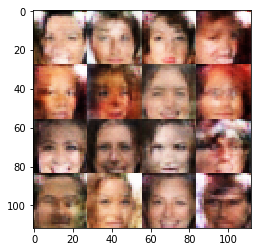

Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 2.0830
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 4.4050
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 3.2621
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.3243
Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 3.2718
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 3.0286
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 4.5873
Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 4.0771


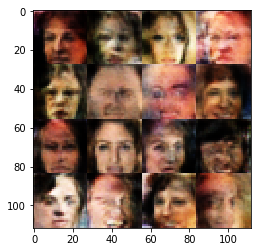

Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 2.9803
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 0.0782... Generator Loss: 3.8129
Epoch 1/1... Discriminator Loss: 0.3005... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 1.9169
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 2.8649
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 2.4817


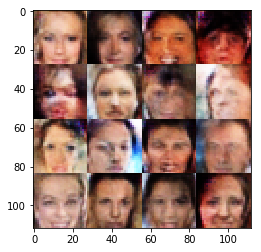

Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 4.6970
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 2.6485
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 5.1450
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 3.9985... Generator Loss: 0.0740
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 3.1936
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 2.7472
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 0.9209


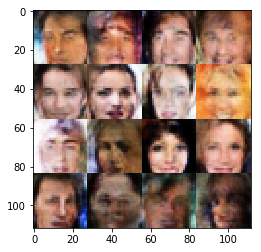

Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.9306
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 2.1244
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 5.7170
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 2.0589


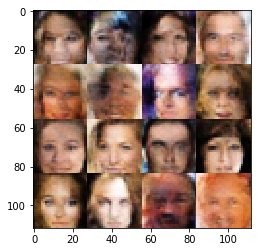

Epoch 1/1... Discriminator Loss: 0.1907... Generator Loss: 2.2315
Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 2.3309
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 4.1699
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 5.2880
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 3.3968
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.1450


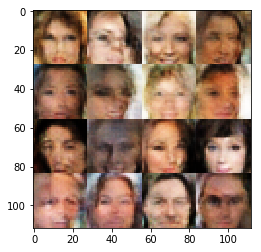

Epoch 1/1... Discriminator Loss: 0.2151... Generator Loss: 2.1572
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 1.7062
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.3991
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.5861
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 3.5701
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 3.3321
Epoch 1/1... Discriminator Loss: 0.3252... Generator Loss: 2.0884
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 1.9696


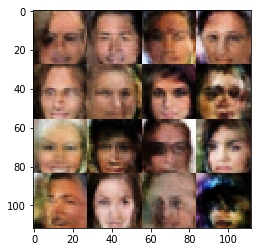

Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 2.0382
Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 1.7699
Epoch 1/1... Discriminator Loss: 0.3125... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 5.5639
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 2.9771


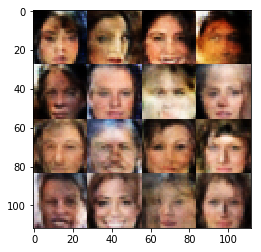

Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 2.4097
Epoch 1/1... Discriminator Loss: 3.2550... Generator Loss: 0.0860
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 2.7210
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 4.9322
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 5.7896
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.3296


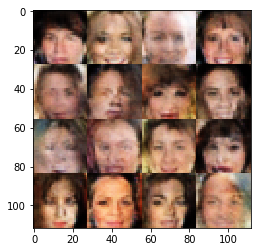

Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 2.3679
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 0.0344... Generator Loss: 7.5018
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.2538... Generator Loss: 1.8443
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.2033
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 0.9149


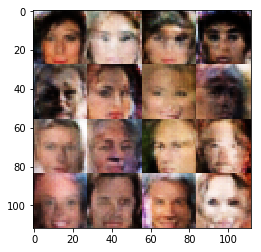

Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 4.5553
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.0653


In [52]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.